# Crowd Counting
by ohmdsp

This notebook will step you through the process of training and testing a deep learning model for estimating crowd density. The output heatmap (i.e., density map) can be used to compute an estimate of the total number of peaople in an image. Note - the same model could be trained to count other objects (i.e., vehicles, fruit, microscopic organisms, etc.). 

The model in this notebook is based on the model in the paper [CSRNet: Dilated Convolutional Neural Networks for Understanding the Highly Congested Scenes](https://arxiv.org/abs/1802.10062).

### Results:

TBD   

### Dataset:

ShanghaiTech dataset

### Training Parameters:

1. *Loss* = MSE;

2. *Optimizer* = SGD(lr=1e-6);

3. *Batch size*: 1;

4. *Data augmentation*: Flip horizontally randomly;

5. *Weights*: Got best weights of SHB in epoch xxx, the best one of SHA in epoch xxx   

In [1]:
import os
import cv2
import time
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as CM
from PIL import Image
import h5py
import math
import glob
import sys

from tensorflow.python.keras import metrics
from tensorflow.python.keras.initializers import RandomNormal
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.optimizers import SGD, Adam
from tensorflow.python.keras.models import Model,Sequential
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, multiply, BatchNormalization, ReLU, Activation
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import model_from_json
import tensorflow as tf

In [2]:
tf.compat.v1.enable_v2_behavior()
tf.enable_eager_execution()

In [3]:
K.clear_session()
root = '/data/crowd_counting/ShanghaiTech/'

In [4]:
part_A_train = os.path.join(root,'part_A/train_data','images')
part_A_test = os.path.join(root,'part_A/test_data','images')
part_B_train = os.path.join(root,'part_B/train_data','images')
part_B_test = os.path.join(root,'part_B/test_data','images')

temp = 'test_images'
train_path_sets = [part_B_train]
test_path_sets = [part_B_test]

In [5]:
files = [os.path.join(part_B_train, file_i)
        for file_i in os.listdir(part_B_train)
        if '.jpg' in file_i]

File[100] path is:  /data/crowd_counting/ShanghaiTech/part_B/train_data/images/IMG_148.jpg


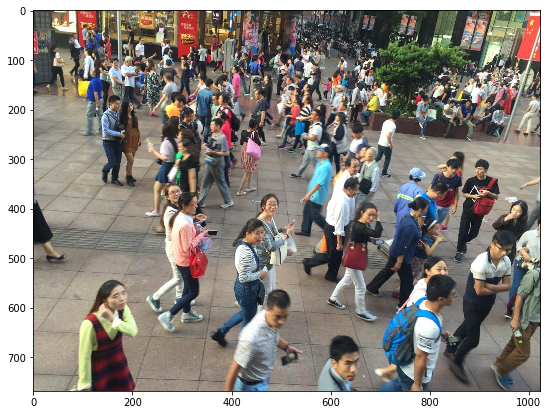

In [6]:
plt.rcParams["figure.figsize"] = (12,7)   # set plot sizes
print('File[100] path is: ', files[100])
img = plt.imread(files[100])
plt.imshow(img)

In [7]:
print('Image shape is: ', img.shape)
print('Image type is: ', img.dtype)
print('min/max size = ', np.min(img), np.max(img))

Image shape is:  (768, 1024, 3)
Image type is:  uint8
min/max size =  0 255


In [8]:
# generate training image paths
train_img_paths = []

for path in train_path_sets:
    
    for train_img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        train_img_paths.append(str(train_img_path))
        
print("Total images : ",len(train_img_paths))
print("Example path is: ", train_img_paths[100])

Total images :  400
Example path is:  /data/crowd_counting/ShanghaiTech/part_B/train_data/images/IMG_148.jpg


In [9]:
# generate test image paths
test_img_paths = []

for path in test_path_sets:
    
    for test_img_path in glob.glob(os.path.join(path, '*.jpg')):
        
        test_img_paths.append(str(test_img_path))
        
print("Total images : ",len(test_img_paths))
print("Example path is: ", test_img_paths[100])

Total images :  316
Example path is:  /data/crowd_counting/ShanghaiTech/part_B/test_data/images/IMG_278.jpg


In [10]:
# Setup some variables
num_train_images = len(train_img_paths)
num_test_images = len(test_img_paths)
print('Number of training images: ', num_train_images)
print('Number of test images: ', num_test_images)
batch_size = 1
num_epochs = 60

Number of training images:  400
Number of test images:  316


In [11]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB') 
    im = np.array(im)
    #print('min/max size = ', np.min(jnk), np.max(jnk))   
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225
    
    #im = im.astype('float32')
    return im

In [12]:
jnk = create_img(train_img_paths[100])
print('Image shape is: ', jnk.shape)
print('Image type is: ', jnk.dtype)
print('min/max size = ', np.min(jnk[:,:,1]), np.max(jnk[:,:,1]))

Image shape is:  (768, 1024, 3)
Image type is:  float64
min/max size =  -2.0357142857142856 2.428571428571429


In [13]:
def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)

In [14]:
def get_output(path):
    #import target density map and resize target to 1/8 input size since netwrok downsamples to 1/8 input size
    gt_file = h5py.File(path,'r')
    target = np.asarray(gt_file['density'])
    ## Note - multiply by 64 due to 1/8 downsample, then multiply by another 64 to boost pixel values in order to train (ignore edge artifacts)
    img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64*64 
    img = np.expand_dims(img,axis  = 2) 
    return img

In [15]:
# def get_input_hm(path):
#     #import target density map and resize target to 1/8 input size since netwrok downsamples to 1/8 input size
#     gt_file = h5py.File(path,'r')
#     target = np.asarray(gt_file['density'])
#     img = cv2.resize(target,(int(target.shape[1]),int(target.shape[0])),interpolation = cv2.INTER_LINEAR)*1024*64
     
#     img = np.expand_dims(img,axis  = 2) 
#     #img = np.stack((img,)*3, axis=-1)    
#     #print(img.shape)
    
#     return img

In [16]:
jnk = get_output('/data/crowd_counting/ShanghaiTech/part_B/train_data/ground/IMG_148.h5')
jnk.shape
#jnk = get_input_hm('/data/crowd_counting/ShanghaiTech/part_B/train_data/ground/IMG_148.h5')
#jnk.shape

(96, 128, 1)

In [17]:
# Let's test this last function's calls and look at a sample density plot (i.e. heatmap) and get ground-truth count
test_heatmap_path = train_img_paths[100].replace('.jpg','.h5').replace('images','ground')
test_heatmap_path

'/data/crowd_counting/ShanghaiTech/part_B/train_data/ground/IMG_148.h5'

Ground-Truth Sum =  276.95767


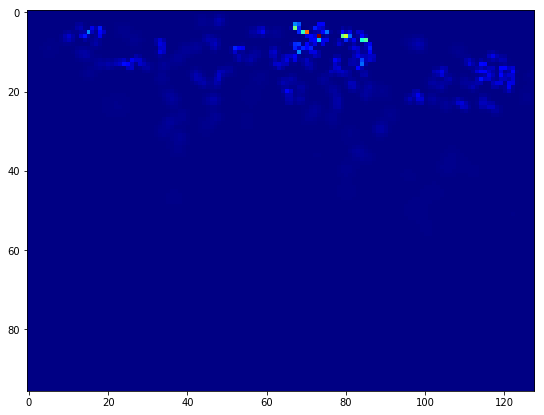

In [18]:
gt_file = h5py.File(test_heatmap_path,'r')
target = np.asarray(gt_file['density'])
img = cv2.resize(target,(int(target.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64   ## 8 x 8 = 64 
plt.imshow(img,cmap=CM.jet)
print("Ground-Truth Sum = " ,np.sum(img))

In [19]:
print('Image shape is: ', img.shape)
print('Image type is: ', img.dtype)
print('min/max size = ', np.min(img), np.max(img))

Image shape is:  (96, 128)
Image type is:  float32
min/max size =  -0.03237441 6.6073246


In [20]:
#def preprocess_input(image,target):
#    #crop image and crop target
#    #resize target
#    crop_size = (int(image.shape[1]/2),int(image.shape[2]/2))
#    crop_size_target = (int(target.shape[1]/2),int(target.shape[2]/2))
    
    
#    if random.randint(0,9)<= 1:            
#            dx = int(random.randint(0,1)*image.shape[1]*1./2)
#            dy = int(random.randint(0,1)*image.shape[2]*1./2)
#            dxt = int(random.randint(0,1)*target.shape[1]*1./2)
#            dyt = int(random.randint(0,1)*target.shape[2]*1./2)
#            
#    else:
#            dx = int(random.random()*image.shape[1]*1./2)
#            dy = int(random.random()*image.shape[2]*1./2)
#            dxt = int(random.random()*target.shape[1]*1./2)
#            dyt = int(random.random()*target.shape[2]*1./2)
#
#    #print(crop_size , dx , dy)
#    img = image[:, dx:crop_size[0]+dx , dy:crop_size[1]+dy, :]
#    target_aug = target[:,dxt:crop_size_target[0]+dxt,dyt:crop_size_target[1]+dyt,:]
#    
#    print(img.shape)
#    print(target_aug.shape)
#
#    return(img,target_aug)

In [21]:
def flip_horizontally(x, y):
    to_flip = np.random.randint(0, 2)
    if to_flip:
        #x = np.squeeze(x)
        #y = np.squeeze(y)
        #x, y = cv2.flip(x, 1), np.expand_dims(cv2.flip(np.squeeze(y), 1), axis=-1)
        x = cv2.flip(x, 1)
        y = cv2.flip(y, 1)
        # Suppose shape of y is (123, 456, 1), after cv2.flip, shape of y would turn into (123, 456).
    return x, y

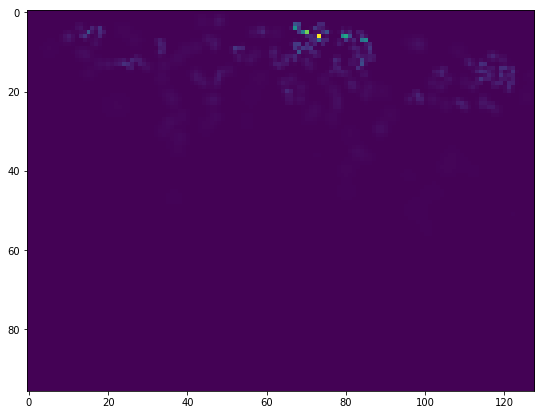

In [22]:
plt.imshow(img)

In [23]:
#x, y = flip_horizontally(img, img)
#x.shape
#plt.imshow(x)

In [24]:
#Image data generator 
def image_generator(files, batch_size):
    
    while True:
        
        input_path = np.random.choice(a = files, size = batch_size, replace=False)
        
        batch_input = []
        batch_output = [] 
            
        inputt = get_input(input_path)
        #inputt = get_input_hm(input_path[0].replace('.jpg','.h5').replace('images','ground') )  # for testing with heatmap as input and output
        output = get_output(input_path[0].replace('.jpg','.h5').replace('images','ground') )
     
        inputt, output = flip_horizontally( np.squeeze(inputt), np.squeeze(output))
        #print(inputt.shape)
        #print(output.shape)
        output = np.expand_dims(output,axis  = 2)
              
        batch_input += [inputt]
        batch_output += [output]
        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
             
        yield( batch_x, batch_y)

In [25]:
#jnkit = image_generator(train_img_paths[0:5],1)

In [26]:
#batch_x, batch_y = next(jnkit)
#batch_x.shape
#batch_y.shape

In [27]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [28]:
@tf.function
def euclidean_distance_loss(y_true, y_pred):
    # Euclidean distance as a measure of loss (Loss function) 
    sub_var = tf.math.square(y_pred - y_true)
    #tf.print('Sub_var: ', sub_var)
    sum_square = tf.math.reduce_sum(sub_var)
    #tf.print('Sum_square: ', sum_square.shape, sum_square)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [29]:
# Neural network model : VGG + Conv
def CrowdNet():  
            #Variable Input Size
            rows = None
            cols = None
            channels = 3
            
            #Batch Normalisation option
            
            #batch_norm = 0
            kernel = (3, 3)
            init = RandomNormal(stddev=0.01)
            
            
            
            model = Sequential()
            model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same',input_shape = (rows, cols, channels), kernel_initializer = init))
            model.add(Conv2D(64, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            model.add(MaxPooling2D(strides=2))
            model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(128,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(MaxPooling2D(strides=2))
            model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(256,kernel_size = kernel, activation = 'relu', padding='same', kernel_initializer = init))
            model.add(MaxPooling2D(strides=2))            
            model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
            model.add(Conv2D(512, kernel_size = kernel,activation = 'relu', padding='same', kernel_initializer = init))
                
                
            #Conv2D
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(512, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(256, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(128, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(64, (3, 3), activation='relu', dilation_rate = 2, kernel_initializer = init, padding = 'same'))
            model.add(Conv2D(1, (1, 1), activation='relu', dilation_rate = 1, kernel_initializer = init, padding = 'same', name = 'output'))
        
            front_end = VGG16(weights='imagenet', include_top=False)
            
            weights_front_end = []
            for layer in front_end.layers:
                if 'conv' in layer.name:
                    weights_front_end.append(layer.get_weights())
            
            counter_conv = 0
            for i in range(len(model.layers)):
                if counter_conv >= 13:
                    break
                if 'conv' in model.layers[i].name:
                    model.layers[i].set_weights(weights_front_end[counter_conv])
                    counter_conv += 1
            
            #model = init_weights_vgg(model)
        
            return model

In [30]:
#strategy = tf.distribute.MirroredStrategy()
#with strategy.scope():
#    model = CrowdNet()
model = CrowdNet()

In [31]:
x = np.random.random((1,768,1024,3)).astype('float32')
#x = np.random.random((1,768,1024,1)).astype('float32')

In [32]:
model(x).shape

TensorShape([1, 96, 128, 1])

In [33]:
sgd = SGD(lr = 1e-6, decay = (1e-4), momentum = 0.95)
#adam = Adam(lr = 1e-4, decay = (5*1e-3))
model.compile(optimizer=sgd, loss=euclidean_distance_loss, metrics=['mse'])
#model.compile(optimizer=adam, loss=euclidean_distance_loss, metrics = ['mse'])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 64)    1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 64)    0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 128)   73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)   147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 128)   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 256)   2

In [35]:
train_gen = image_generator(train_img_paths,batch_size)

In [36]:
test_gen = image_generator(test_img_paths,batch_size)

In [37]:
# Save the model according to the conditions 
#from tensorflow.python.keras.callbacks import ModelCheckpoint
#model_save_path = '/data/crowd_counting/saved_models/'
#model_name = 'crowd_counting_model'  
#checkpoint = ModelCheckpoint(model_save_path+model_name+"_epoch{epoch:02d}-loss{loss:.2f}.h5", monitor='loss', verbose=1, save_best_only=True,  mode='max' )

In [38]:
#callbacks_list = [checkpoint]

In [39]:
print("Training w/ generator...")
H = model.fit_generator(
    train_gen,
    steps_per_epoch = num_train_images // batch_size,
    #callbacks=callbacks_list,
    #workers=4,
    validation_data = test_gen,
    validation_steps = num_test_images // batch_size,
    epochs = num_epochs)

Training w/ generator...
Epoch 1/60
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
400/400 [==============================] - 112s 279ms/step - loss: 315.6106 - mse: 16.5567 - val_loss: 306.5511 - val_mse: 15.7715
Epoch 2/60
400/400 [==============================] - 99s 247ms/step - loss: 347.4008 - mse: 18.6982 - val_loss: 330.1033 - val_mse: 18.1485
Epoch 3/60
400/400 [==============================] - 99s 247ms/step - loss: 313.9788 - mse: 15.6578 - val_loss: 317.8043 - val_mse: 17.8403
Epoch 4/60
400/400 [==============================] - 100s 249ms/step - loss: 286.9824 - mse: 13.5516 - val_loss: 320.8674 - val_mse: 17.0927
Epoch 5/60
400/400 [==============================] - 99s 247ms/step - loss: 293.5869 - mse: 14.4573 - val_loss: 257.2221 - val_mse: 11.6827
Epoch 6/60
400/400 [==============================] - 99s 246ms/step - loss: 286.6365 - mse: 14.4074 - val_loss: 232.6349 - val_mse: 9.8641
Epoch 7/60
400/400 [==============

Epoch 57/60
400/400 [==============================] - 98s 245ms/step - loss: 193.5957 - mse: 6.8929 - val_loss: 224.2469 - val_mse: 10.1560
Epoch 58/60
400/400 [==============================] - 99s 247ms/step - loss: 210.2197 - mse: 7.9661 - val_loss: 207.4097 - val_mse: 7.5741
Epoch 59/60
400/400 [==============================] - 99s 247ms/step - loss: 175.5702 - mse: 5.5588 - val_loss: 193.1525 - val_mse: 7.1391
Epoch 60/60
400/400 [==============================] - 99s 247ms/step - loss: 206.0996 - mse: 7.4904 - val_loss: 209.7882 - val_mse: 7.5642


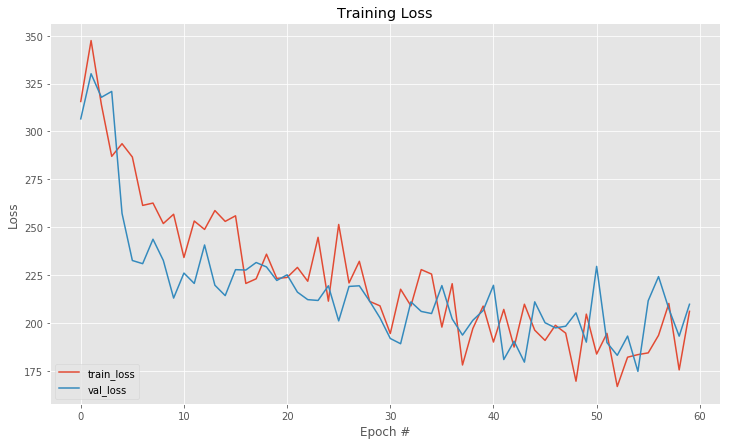

In [40]:
# plot the training loss and accuracy
N = num_epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
#plt.plot(np.arange(0, N), H.history["mse"], label="train_mse")
#plt.plot(np.arange(0, N), H.history["val_mean_squared_error"], label="val_mse")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [ ]:
#save_mod(model,"/data/crowd_counting/weights/model_A_weights.h5","/data/crowd_counting/models/Model_A.json")
#model.save('/data/crowd_counting/saved_models/crowd_counting_modelA_2_51epochs.h5')

In [ ]:
# def load_model():
#     # Function to load and return neural network model 
#     json_file = open('/data/crowd_counting/models/Model_B.json', 'r')
#     #json_file = open('/data/crowd_counting/models/ModelA.json', 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
#     loaded_model = model_from_json(loaded_model_json)
#     loaded_model.load_weights("/data/crowd_counting/weights/model_B_weights.h5")
#     #loaded_model.load_weights("/dml/notebooks/CSRNet-keras/weights/pretrained.h5")
#     return loaded_model

In [41]:
def create_img_test(path):
    #Function to load,normalize and return image 
    im = Image.open(path)
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225

    im = np.expand_dims(im, axis = 0)
    return im

In [42]:
## Try some predictions to view output of model
def predict(path):
    #Function to load image,predict heat map, generate count and return (count , image , heat map)
    #model = load_model()
    image = create_img_test(path)
    ans = model.predict(image)
    count = np.sum(ans)
    return count,image,ans

Ground Truth People Count =  163
Input Image Path:  /data/crowd_counting/ShanghaiTech/part_B/test_data/images/IMG_127.jpg


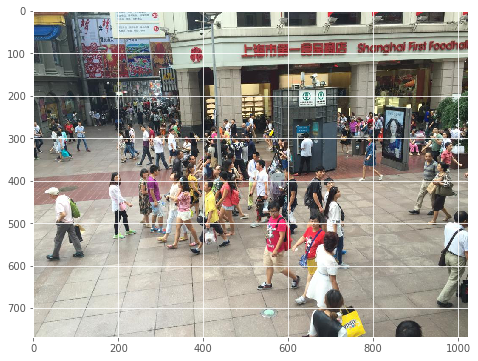

Estimated People Count =  138.765625


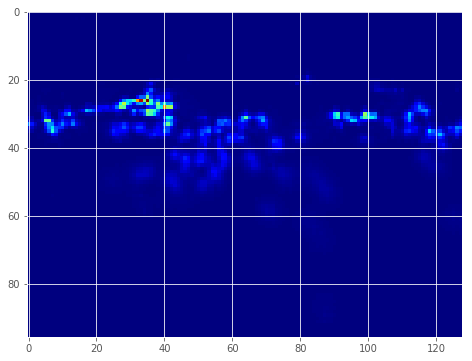

In [43]:
## use a test image to check the prediction (e.g., inference)
plt.rcParams["figure.figsize"] = (10,6)   # set plot sizes
test_image = test_img_paths[32]
#test_image = '/data/airport_lines/001.jpg'

test_heatmap_truth = test_image.replace('.jpg','.h5').replace('images','ground')
## Get the Ground Truth heatmap
gt_file = h5py.File(test_heatmap_truth,'r')
groundtruth = np.asarray(gt_file['density'])
groundtruth = cv2.resize(groundtruth,(int(groundtruth.shape[1]/8),int(target.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64   ## 8 x 8 = 64
#plt.imshow(groundtruth,cmap=CM.jet)
print("Ground Truth People Count = " ,int(np.sum(groundtruth)))
#print('Ground Truth Heat Map Dimensions: ', groundtruth.shape)
#print('Image type is: ', groundtruth.dtype)
#print('min/max size = ', np.min(groundtruth), np.max(groundtruth))
#plt.show()

# get the input image
count,image,hmap = predict(test_image)
width = image.shape[2]
height = image.shape[1]
channels = image.shape[3]
print('Input Image Path: ', test_image)
#print('Input Image dimensions: ', width, 'x ', height, 'x ', channels)
input_image = Image.open(test_image)
plt.imshow(input_image)
#plt.imshow(image.reshape(height,width,channels))
plt.show()

# predicted heat map info 
hwidth = hmap.shape[2]
hheight = hmap.shape[1]
hchannels = hmap.shape[3]
#print('Output Heat Map Dimensions: ', hwidth, 'x ', hheight, 'x ', hchannels)
print('Estimated People Count = ', int(count) / 64)
plt.imshow(hmap.reshape(hheight,hwidth), cmap = CM.jet )
plt.show()
